Coursera Question 6-10

9,10請參考連結


In [56]:
%matplotlib inline
import numpy as np
np.random.seed(0413)
import matplotlib.pyplot as plt
from keras.models import *
import main

npz = np.load('./train.npz')
    
img = npz['x']
text = npz['y']

g,d,m = main.gan_model(64,22,100)
m.load_weights('./b.h5')

print 'Done'
# plt.plot(r,c,'r-')
# plt.show()


Done


(1, 100) (1, 22)
(64, 64, 3)


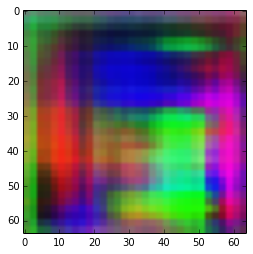

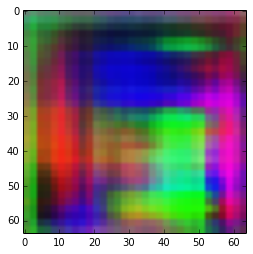

In [57]:
n = main.noise_sample(100,1)
c = main.condition_seq()[0:1,:]
print n.shape,c.shape

im = g.predict([n,c]).reshape(64,64,3)
print im.shape
np.set_printoptions(threshold='nan')
plt.imshow(im)
plt.show()
im2 = im*255
im2 = im2.astype(np.uint8)
plt.imshow(im2)
plt.show()


Coursera Q18-20

In [9]:
# -*- coding: utf-8 -*-
"""
Train an Auxiliary Classifier Generative Adversarial Network (ACGAN) on the
MNIST dataset. See https://arxiv.org/abs/1610.09585 for more details.

You should start to see reasonable images after ~5 epochs, and good images
by ~15 epochs. You should use a GPU, as the convolution-heavy operations are
very slow on the CPU. Prefer the TensorFlow backend if you plan on iterating,
as the compilation time can be a blocker using Theano.

Timings:

Hardware           | Backend | Time / Epoch
-------------------------------------------
 CPU               | TF      | 3 hrs
 Titan X (maxwell) | TF      | 4 min
 Titan X (maxwell) | TH      | 7 min

Consult https://github.com/lukedeo/keras-acgan for more information and
example output
"""
%matplotlib inline
import numpy as np
np.random.seed(0413)
import matplotlib.pyplot as plt
from keras.models import *
import main

from __future__ import print_function

from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image

from six.moves import range

from keras.datasets import mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np

np.random.seed(1337)
num_classes = 10


def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 28, 28, 1)
    cnn = Sequential()

    cnn.add(Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
    cnn.add(Reshape((3, 3, 384)))

    # upsample to (7, 7, ...)
    cnn.add(Conv2DTranspose(192, 5, strides=1, padding='valid',
                            activation='relu',
                            kernel_initializer='glorot_normal'))

    # upsample to (14, 14, ...)
    cnn.add(Conv2DTranspose(96, 5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal'))

    # upsample to (28, 28, ...)
    cnn.add(Conv2DTranspose(1, 5, strides=2, padding='same',
                            activation='tanh',
                            kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    cls = Flatten()(Embedding(num_classes, latent_size,
                              embeddings_initializer='glorot_normal')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(28, 28, 1)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(28, 28, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])



紙本題Q8 Q9

In [10]:

# batch and latent size taken from the paper
epochs = 50
batch_size = 100
latent_size = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

# build the discriminator
print('Discriminator model:')
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
discriminator.summary()

# build the generator
generator = build_generator(latent_size)

latent = Input(shape=(latent_size, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model([latent, image_class], [fake, aux])

print('Combined model:')
combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
combined.summary()

# get our mnist data, and force it to be of shape (..., 28, 28, 1) with
# range [-1, 1]
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

x_test = (x_test.astype(np.float32) - 127.5) / 127.5
x_test = np.expand_dims(x_test, axis=-1)

num_train, num_test = x_train.shape[0], x_test.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)



Discriminator model:
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_21 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
sequential_9 (Sequential)        (None, 12544)         387840      input_21[0][0]                   
____________________________________________________________________________________________________
generation (Dense)               (None, 1)             12545       sequential_9[1][0]               
____________________________________________________________________________________________________
auxiliary (Dense)                (None, 10)            125450      sequential_9[1][0]               
Total params: 525,835
Trainable params: 525,835
Non-trainable params: 

In [13]:

for epoch in range(1, epochs + 1):
    print('Epoch {}/{}'.format(epoch, epochs))

    num_batches = int(x_train.shape[0] / batch_size)
    progress_bar = Progbar(target=num_batches)

    # we don't want the discriminator to also maximize the classification
    # accuracy of the auxiliary classifier on generated images, so we
    # don't train discriminator to produce class labels for generated
    # images (see https://openreview.net/forum?id=rJXTf9Bxg).
    # To preserve sum of sample weights for the auxiliary classifier,
    # we assign sample weight of 2 to the real images.
    disc_sample_weight = [np.ones(2 * batch_size),
                          np.concatenate((np.ones(batch_size) * 2,
                                          np.zeros(batch_size)))]

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(num_batches):
        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (batch_size, latent_size))

        # get a batch of real images
        image_batch = x_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, num_classes, batch_size)

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (batch_size, 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

        x = np.concatenate((image_batch, generated_images))

        # use soft real/fake labels
        soft_zero, soft_one = 0.1, 0.9
        y = np.array([soft_one] * batch_size + [soft_zero] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(
            x, [y, aux_y], sample_weight=disc_sample_weight))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
        sampled_labels = np.random.randint(0, num_classes, 2 * batch_size)

        # we want to train the generator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * batch_size) * soft_one

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels]))

        progress_bar.update(index + 1)

    print('Testing for epoch {}:'.format(epoch))

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (num_test, latent_size))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, num_classes, num_test)
    generated_images = generator.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=False)

    x = np.concatenate((x_test, generated_images))
    y = np.array([1] * num_test + [0] * num_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(
        x, [y, aux_y], verbose=False)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
    sampled_labels = np.random.randint(0, num_classes, 2 * num_test)

    trick = np.ones(2 * num_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    # generate an epoch report on performance
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *discriminator.metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))

    # save weights every epoch
    generator.save_weights(
        'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
    discriminator.save_weights(
        'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

    # generate some digits to display
    num_rows = 40
    noise = np.tile(np.random.uniform(-1, 1, (num_rows, latent_size)),
                    (num_classes, 1))

    sampled_labels = np.array([
        [i] * num_rows for i in range(num_classes)
    ]).reshape(-1, 1)

    # get a batch to display
    generated_images = generator.predict(
        [noise, sampled_labels], verbose=0)

    # prepare real images sorted by class label
    real_labels = y_train[(epoch - 1) * num_rows * num_classes:
                          epoch * num_rows * num_classes]
    indices = np.argsort(real_labels, axis=0)
    real_images = x_train[(epoch - 1) * num_rows * num_classes:
                          epoch * num_rows * num_classes][indices]

    # display generated images, white separator, real images
    img = np.concatenate(
        (generated_images,
         np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0),
         real_images))

    # arrange them into a grid
    img = (np.concatenate([r.reshape(-1, 28)
                           for r in np.split(img, 2 * num_classes + 1)
                           ], axis=-1) * 127.5 + 127.5).astype(np.uint8)
    Image.fromarray(img).save(
        'plot_epoch_{0:03d}_generated.png'.format(epoch))

pickle.dump({'train': train_history, 'test': test_history},
            open('acgan-history.pkl', 'wb'))




Epoch 1/50
(200,)
(200,)


KeyboardInterrupt: 

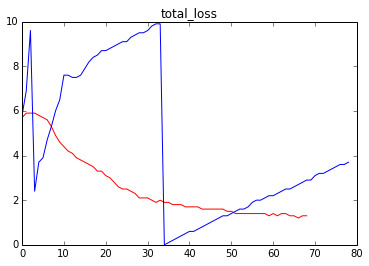

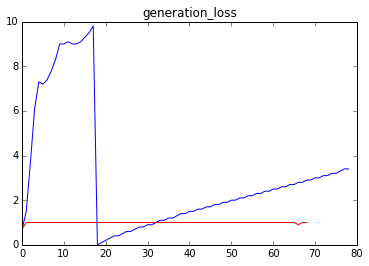

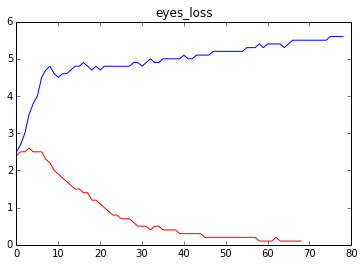

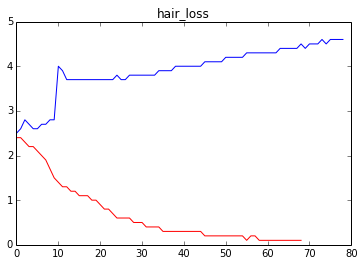

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
def plot(path1,path2):
    with open(path1, 'r') as f:
        buf1 = f.read()

    with open(path2, 'r') as f:
        buf2 = f.read()


    pg = re.compile('generator \(train\).*\d\.\d.*\d\.\d.*\d\.\d.*\d\.\d.*')
    pd = re.compile('discriminator (train).*\d\.\d.*\d\.\d.*\d\.\d.*\d\.\d.*')
    value = re.compile('\d\.\d')
    m1 = pg.findall(buf1)
    m2 = pg.findall(buf2)
    
    loss_list1 = [[] for i in range(4)]
    loss_list2 = [[] for i in range(4)]

    for m in m1:
        for idx,loss in enumerate(value.findall(m)):
            loss_list1[idx].append(float(loss))
    for m in m2:
        for idx,loss in enumerate(value.findall(m)):
            loss_list2[idx].append(float(loss))
    titles = ['total_loss','generation_loss','eyes_loss','hair_loss']
    for loss1,loss2,title in zip(loss_list1, loss_list2, titles):
        x = range(len(loss1))
        plt.plot(x,loss1,'r-')
        x = range(len(loss2))
        plt.plot(x,loss2,'b-')
        plt.title(title)
        plt.show()
plot('./src.out','./nohup.t1')
        
        